In [1]:
library(tidyverse)
library(ISLR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0.9000     ✔ purrr   0.2.5     
✔ tibble  1.4.2          ✔ dplyr   0.7.6     
✔ tidyr   0.8.1          ✔ stringr 1.3.1     
✔ readr   1.2.0          ✔ forcats 0.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## 1. Loading the Data
We load the data in a dataframe and also create a column Type for the cancer types.

In [2]:
nc_data <- as.data.frame(NCI60$data)
nc_data$type <- NCI60$labs

In [3]:
head(nc_data)

,1,2,3,4,5,6,7,8,9,10,⋯,6822,6823,6824,6825,6826,6827,6828,6829,6830,type
V1,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.45000000,-0.65498050,⋯,0.000000,0.030000,-0.175000,0.6299805,-0.030000,0.0000000,0.280000,-0.340000,-1.930000,CNS
V2,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.04003899,-0.28501950,⋯,-0.300039,-0.250039,-0.535039,0.1099415,-0.860039,-1.2500490,-0.770039,-0.390039,-2.000039,CNS
V3,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.43000000,0.47501950,⋯,0.120000,-0.740000,-0.595000,-0.2700195,-0.150000,0.0000000,-0.120000,-0.410000,0.000000,CNS
V4,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.02000000,0.09501949,⋯,-0.110000,-0.160000,0.095000,-0.3500195,-0.300000,-1.1500100,1.090000,-0.260000,-1.100000,RENAL
V5,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.23500000,1.49001949,⋯,-0.775000,-0.515000,-0.320000,0.6349805,0.605000,0.0000000,0.745000,0.425000,0.145000,BREAST
V6,0.310000,-0.030000,-0.100000,-0.460000,-0.205000,-5.400000e-01,-0.640000,-0.585000,-0.77000000,-0.24498050,⋯,0.000000,-0.740000,-2.095000,-1.3900200,-0.400000,0.6999902,0.290000,0.550000,0.000000,CNS


## 2. False Discovery Rate and T-Test Functions

In [4]:
mytfunc <- function(x){
    # Calculate the mean, standard deviation and length of the input vector
    xbar <- mean(x)
    sd0 <- sd(x, na.rm = TRUE)
    n <- length(x)

    # We define the t-statistic
    tstat <- xbar/(sd0/sqrt(n))
    
    # Perform a one-sample t-test using the inbuilt pt() function. We calculate
    # the probability of getting a number
    # less than the t-statistic.
    p0 <- pt(tstat, n-1)
    
    c(p0, 1-p0)
}

In [5]:
fdr <- function(v1, Q, gene_type){
    # Rearrange the p-values in increasing order
    o1 <- order(v1)
    pvec <- v1[o1]
    
    # Calculate the length of vector of p-values. Since we are going from smaller 
    # p-value to larger p-value this is called a step-up procedure
    m <- length(v1)
    
    # Calculate the terms - (k/m)*alpha
    qline <- Q*c(1:m)/m
    
    # Find all p-values for which p(k) <= (k/m)*alpha. Here, k = 1,2,3,4...,m 
    # and p(k) is the kth p-value in the vector pvec.
    dv <- pvec - qline
    I1 <- (dv < 0)
    
    # Find the largest k for which p(k) <= (k/m)*alpha
    pmax <- max(pvec[I1], na.rm = TRUE)
    
    # All the p-values less than p(k) are false discoveries
    I2 <- (pvec <= pmax)
    
    # Create some plots
    if (gene_type == "underexpressed"){
        plot(c(c(1:m),c(1:m)), c(qline, pvec), type = "n", xlab = "ordering", 
             ylab = "pvalue", main = "FDR Test for Underexpressed Genes")
    }
    else{
        plot(c(c(1:m),c(1:m)), c(qline, pvec), type = "n", xlab = "ordering", 
             ylab = "pvalue", main = "FDR Test for Overexpressed Genes")
    }
    lines(c(1:m), qline)
    points(c(1:m), pvec)
    
    # Highight all these points in red
    points(c(1:m)[I2], pvec[I2], col = "red")
    
    # Return all genes whose p-values we rejected using FDR above.
    return(o1[I2])
}

## 3. Unique Cancer Types

In [6]:
unique(nc_data$type)

[1] "CNS"         "RENAL"       "BREAST"      "NSCLC"       "UNKNOWN"    
 [6] "OVARIAN"     "MELANOMA"    "PROSTATE"    "LEUKEMIA"    "K562B-repro"
[11] "K562A-repro" "COLON"       "MCF7A-repro" "MCF7D-repro"

## 4. FDR Test of Different Types of Cancers

### 4.1 Function to get the respective cancer data
This is a utility function to get the respective cancer data from the genes dataframe.

In [7]:
get_cancer_data <- function(cancer_type){
    data <- nc_data %>% filter(type == cancer_type)
    data <- data[, !names(data) %in% c("type")]
    return(data)
}

We initialise a significant genes vector where we store all the significant genes we find using the FDR test. We create 2 vectors - one for the underexpressed genes and the other for the overexpressed genes.

In [8]:
significant_overexpressed_genes_vector <- c()
significant_underexpressed_genes_vector <- c()

### 4.2 MCF7D-repro

Warning message in max(pvec[I1], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in max(pvec[I1], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

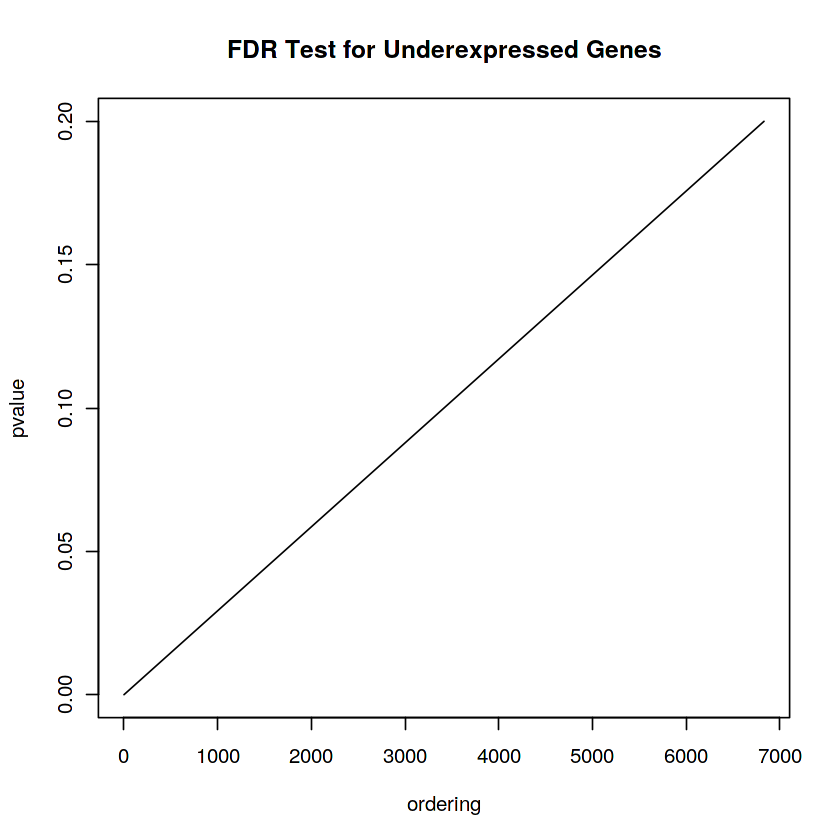

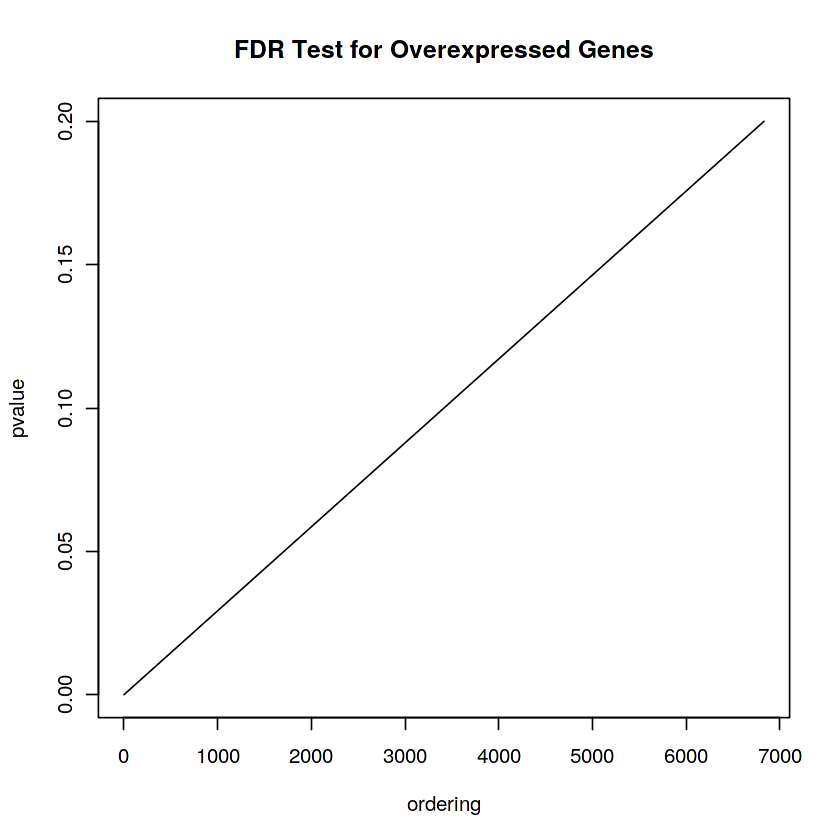

In [9]:
mcf7d_data <- get_cancer_data("MCF7D-repro")
x <- fdr(apply(mcf7d_data, 2, mytfunc)[1,], 0.2, "underexpressed")
y <- fdr(apply(mcf7d_data, 2, mytfunc)[2,], 0.2, "overexpressed")

### 4.3 MCF7A-repro

Warning message in max(pvec[I1], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in max(pvec[I1], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

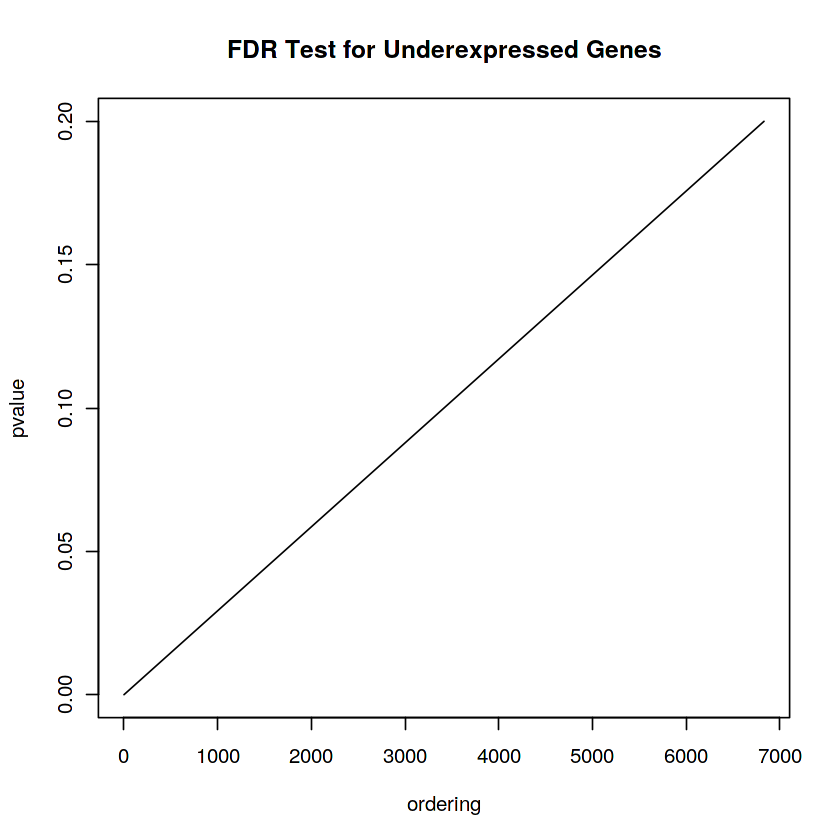

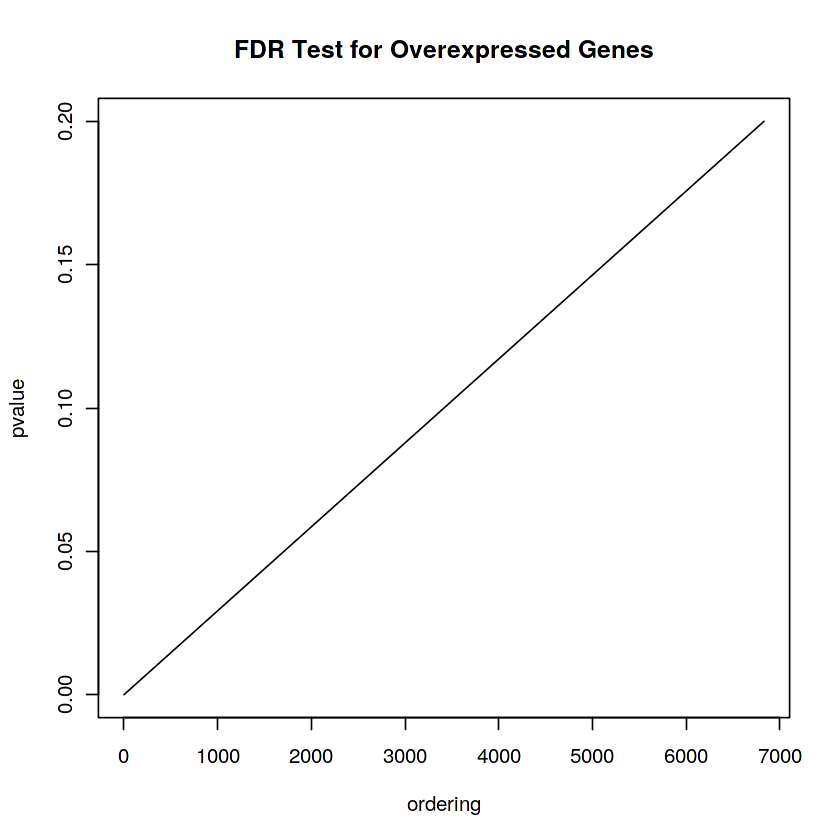

In [10]:
mcf7a_data <- get_cancer_data("MCF7A-repro")
x <- fdr(apply(mcf7a_data, 2, mytfunc)[1,], 0.2, "underexpressed")
y <- fdr(apply(mcf7a_data, 2, mytfunc)[2,], 0.2, "overexpressed")

In the above cancer types, we are getting no graph because there is only **one row of this cancer type** and so no significant p-values can be generated from this cancer type's data. We can simply remove these cancer types from our evaluation.

### 4.4 COLON

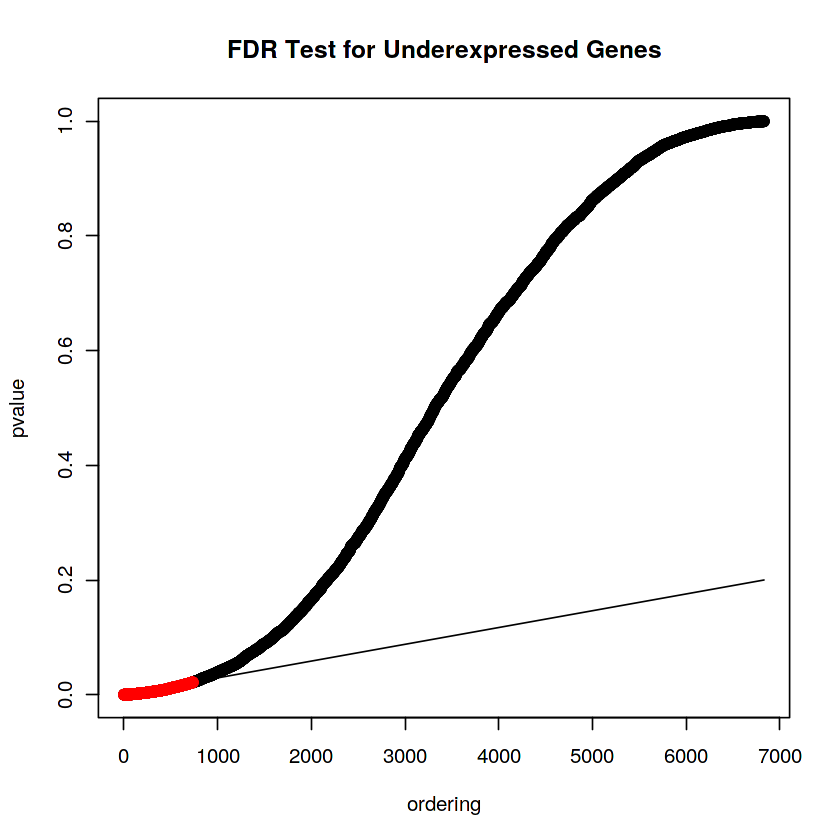

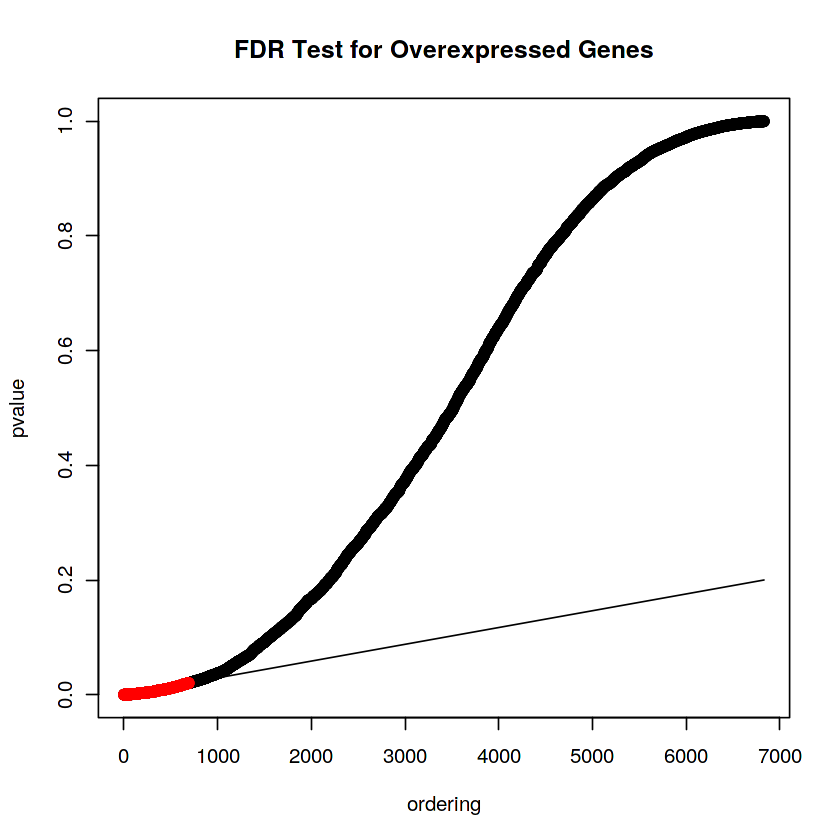

In [11]:
colon_data <- get_cancer_data("COLON")
significant_underexpressed_genes_vector[['COLON']] <- fdr(apply(colon_data, 2, mytfunc)[1,], 
                                                          0.2, "underexpressed")
significant_overexpressed_genes_vector[['COLON']] <- fdr(apply(colon_data, 2, mytfunc)[2,], 
                                                         0.2, "overexpressed")

### 4.5 K562A-repro

Warning message in max(pvec[I1], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in max(pvec[I1], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

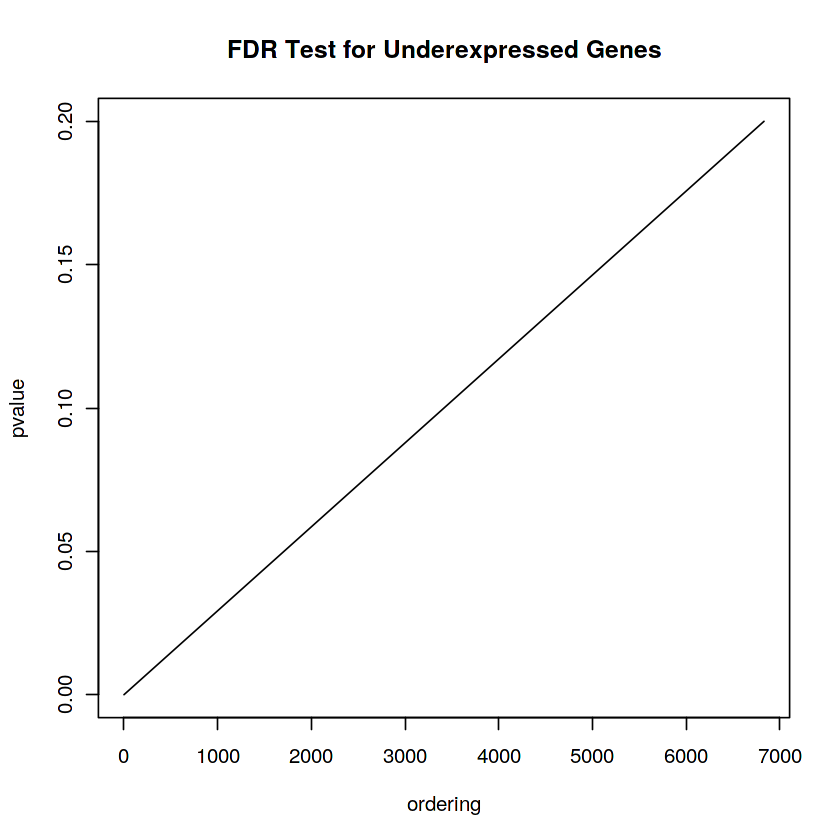

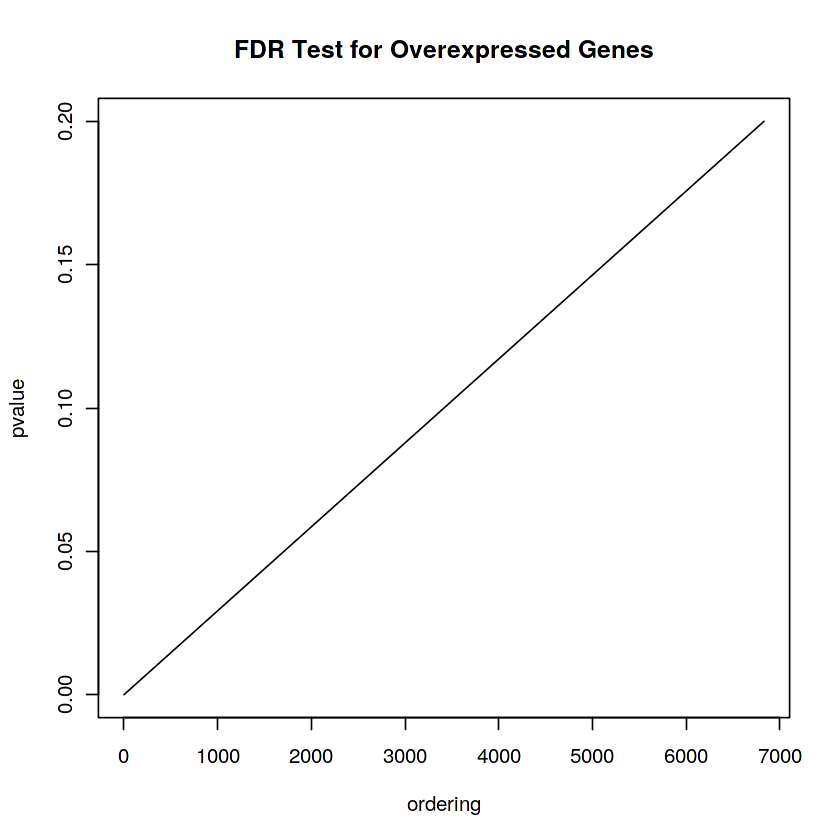

In [12]:
k562a_data <- get_cancer_data("K562A-repro")
x <- fdr(apply(k562a_data, 2, mytfunc)[1,], 0.2, "underexpressed")
y <- fdr(apply(k562a_data, 2, mytfunc)[2,], 0.2, "overexpressed")

### 4.6 K562B-repro

Warning message in max(pvec[I1], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in max(pvec[I1], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

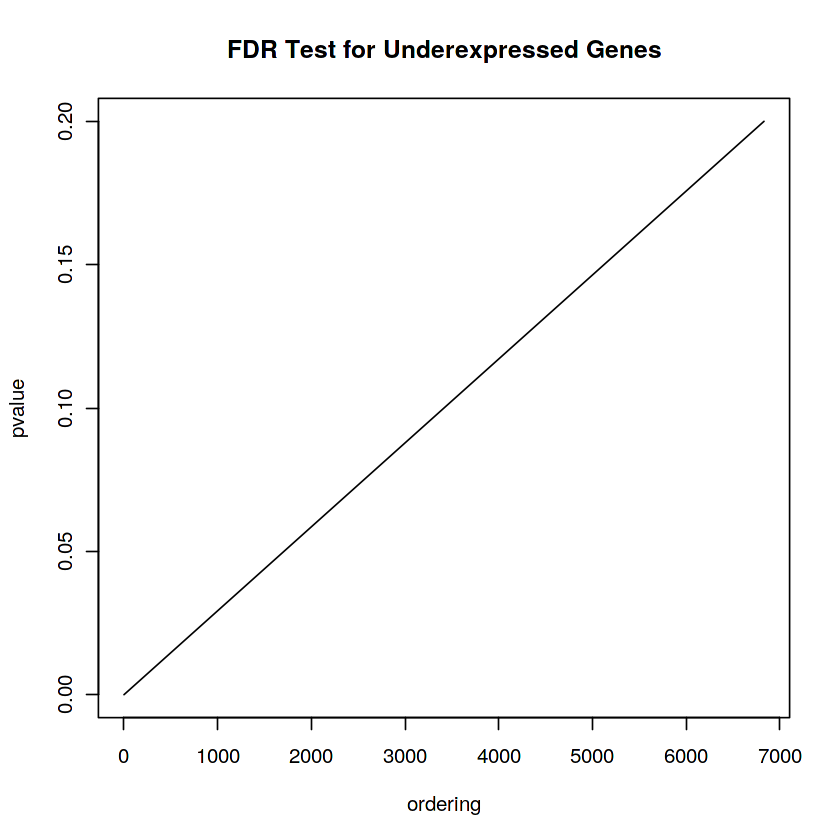

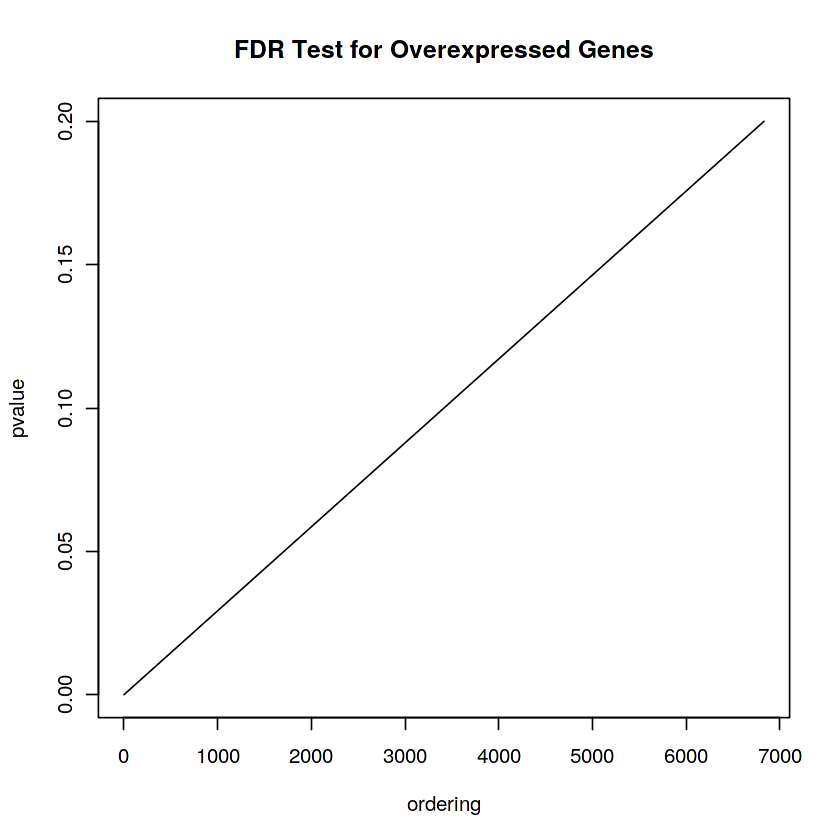

In [13]:
k562b_data <- get_cancer_data("K562B-repro")
x <- fdr(apply(k562b_data, 2, mytfunc)[1,], 0.2, "underexpressed")
y <- fdr(apply(k562b_data, 2, mytfunc)[2,], 0.2, "overexpressed")

Similar to the MCF7A and MCF7D genes, we only have one row in the dataframe for the K562B and K562A genes, 
so we can discard them from our analysis.

### 4.7 LEUKEMIA

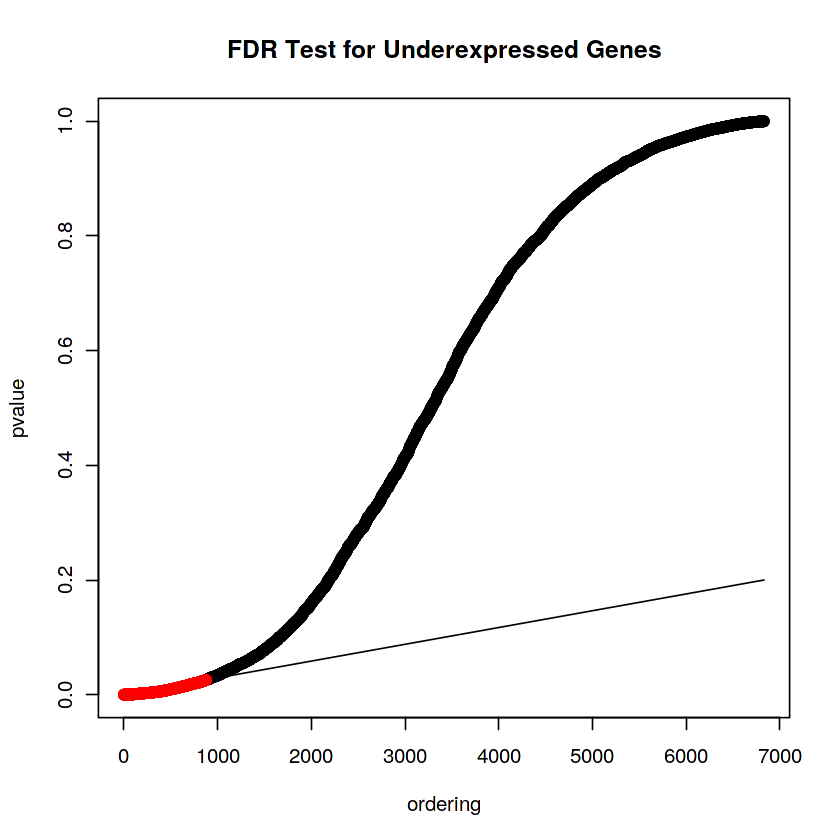

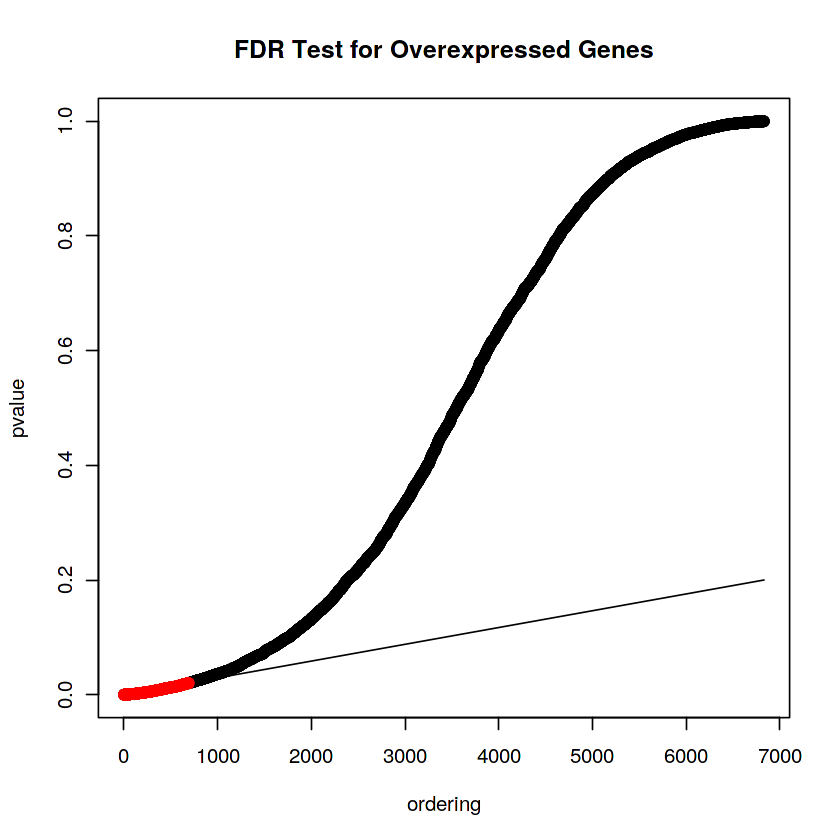

In [14]:
leukemia_data <- get_cancer_data("LEUKEMIA")
significant_underexpressed_genes_vector[['LEUKEMIA']] <- fdr(apply(leukemia_data, 
                                                            2, mytfunc)[1,], 
                                                            0.2, "underexpressed")
significant_overexpressed_genes_vector[['LEUKEMIA']] <- fdr(apply(leukemia_data, 
                                                            2, mytfunc)[2,], 
                                                            0.2, "overexpressed")

### 4.8 PROSTATE

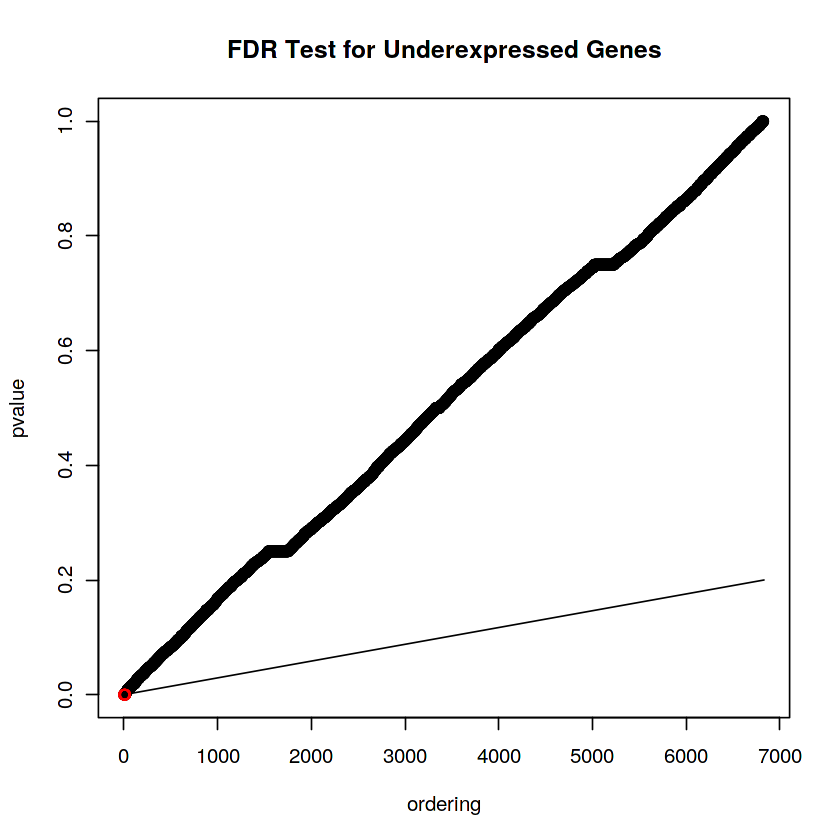

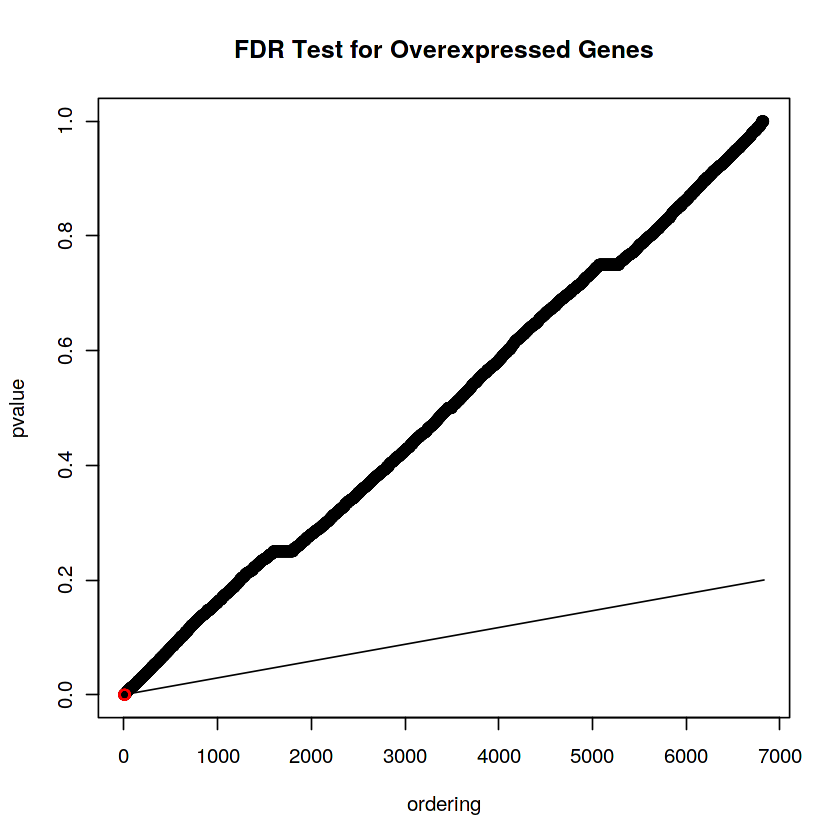

In [15]:
prostate_data <- get_cancer_data("PROSTATE")
significant_underexpressed_genes_vector[['PROSTATE']] <- fdr(apply(prostate_data, 
                                                            2, mytfunc)[1,], 0.2,
                                                            "underexpressed")
significant_overexpressed_genes_vector[['PROSTATE']] <- fdr(apply(prostate_data,
                                                            2, mytfunc)[2,], 0.2, 
                                                            "overexpressed")

### 4.9 MELANOMA

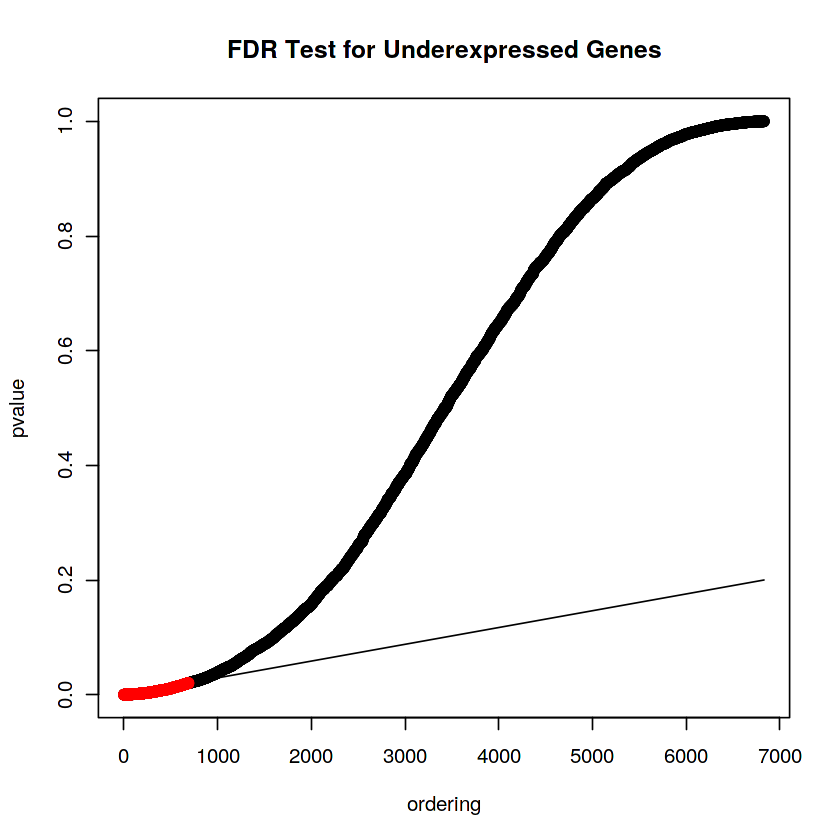

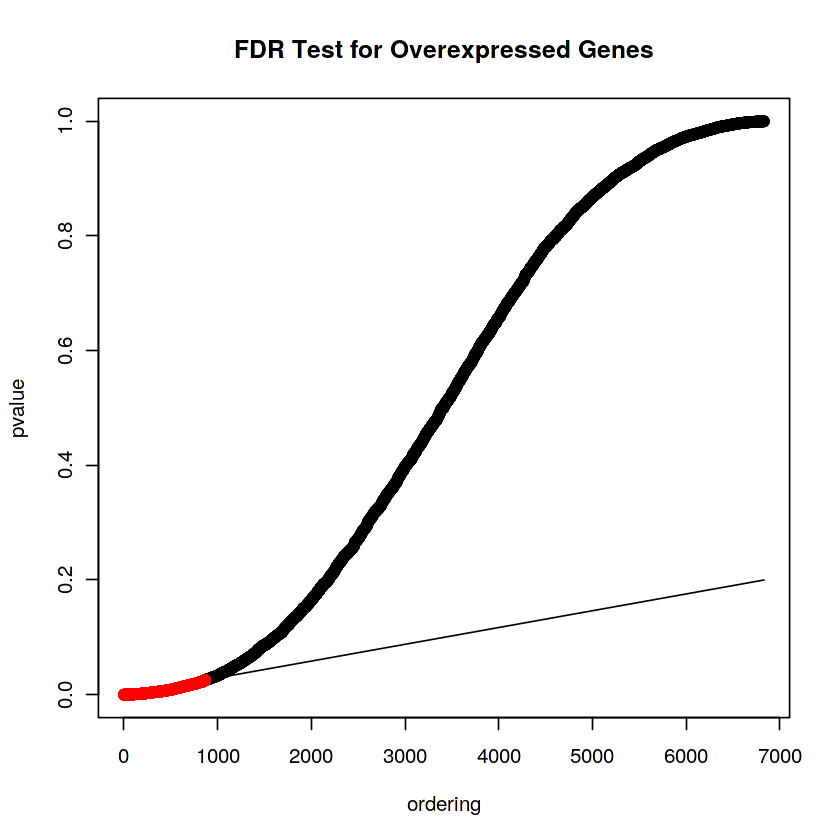

In [16]:
melanoma_data <- get_cancer_data("MELANOMA")
significant_underexpressed_genes_vector[['MELANOMA']] <- fdr(apply(melanoma_data, 
                                                            2, mytfunc)[1,], 0.2, 
                                                            "underexpressed")
significant_overexpressed_genes_vector[['MELANOMA']] <- fdr(apply(melanoma_data, 
                                                            2, mytfunc)[2,], 0.2, 
                                                            "overexpressed")

### 4.10 NSCLC

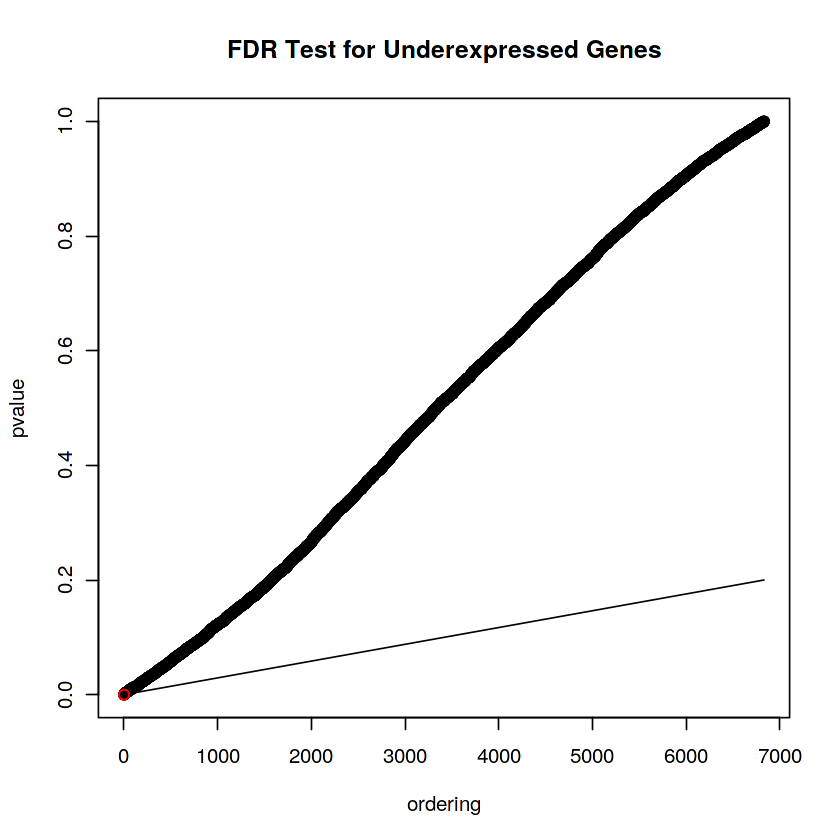

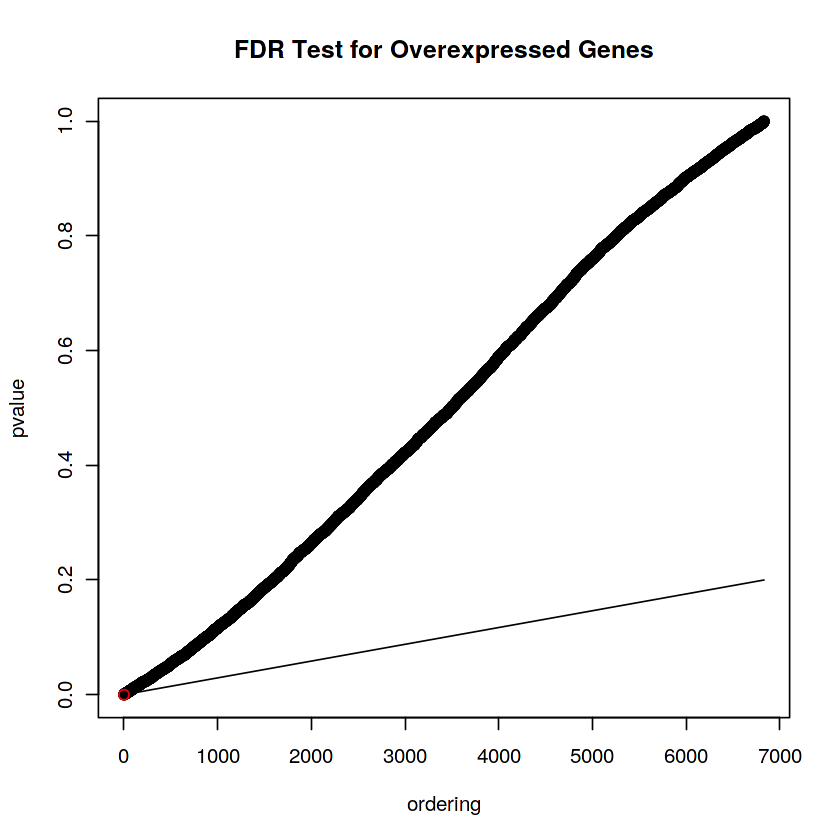

In [17]:
nsclc_data <- get_cancer_data("NSCLC")
significant_underexpressed_genes_vector[['NSCLC']] <- fdr(apply(nsclc_data, 
                                                        2, mytfunc)[1,], 0.2, 
                                                        "underexpressed")
significant_overexpressed_genes_vector[['NSCLC']] <- fdr(apply(nsclc_data, 
                                                        2, mytfunc)[2,], 0.2, 
                                                        "overexpressed")

### 4.11 BREAST

Warning message in max(pvec[I1], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

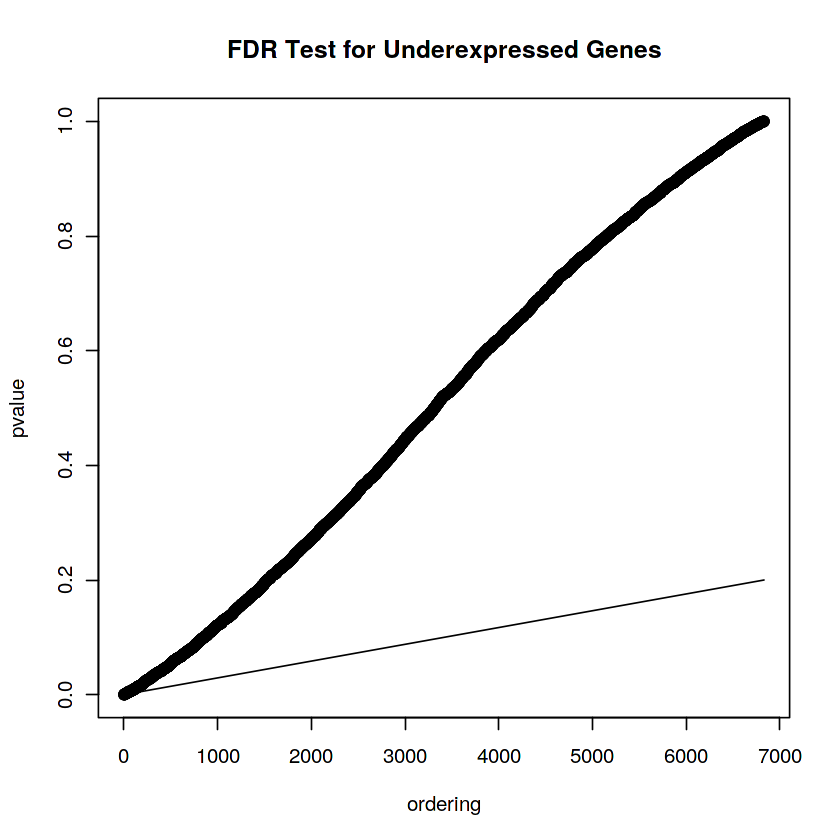

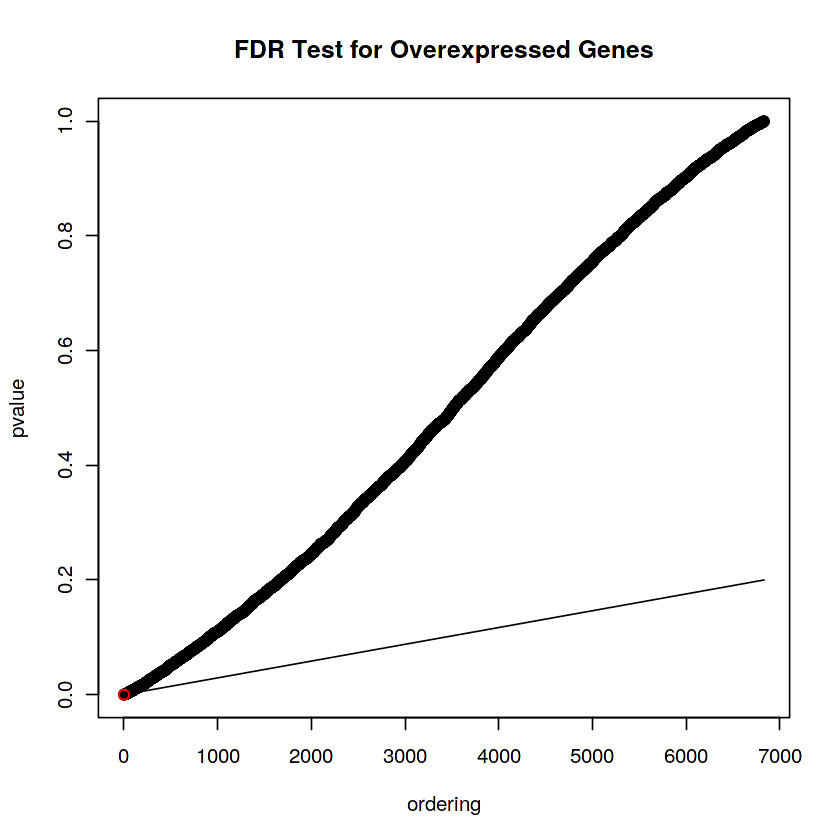

In [18]:
breast_data <- get_cancer_data("BREAST")
significant_underexpressed_genes_vector[['BREAST']] <- fdr(apply(breast_data, 
                                                        2, mytfunc)[1,], 0.2, 
                                                        "underexpressed")
significant_overexpressed_genes_vector[['BREAST']] <- fdr(apply(breast_data, 
                                                        2, mytfunc)[2,], 0.2, 
                                                        "overexpressed")

### 4.12 RENAL

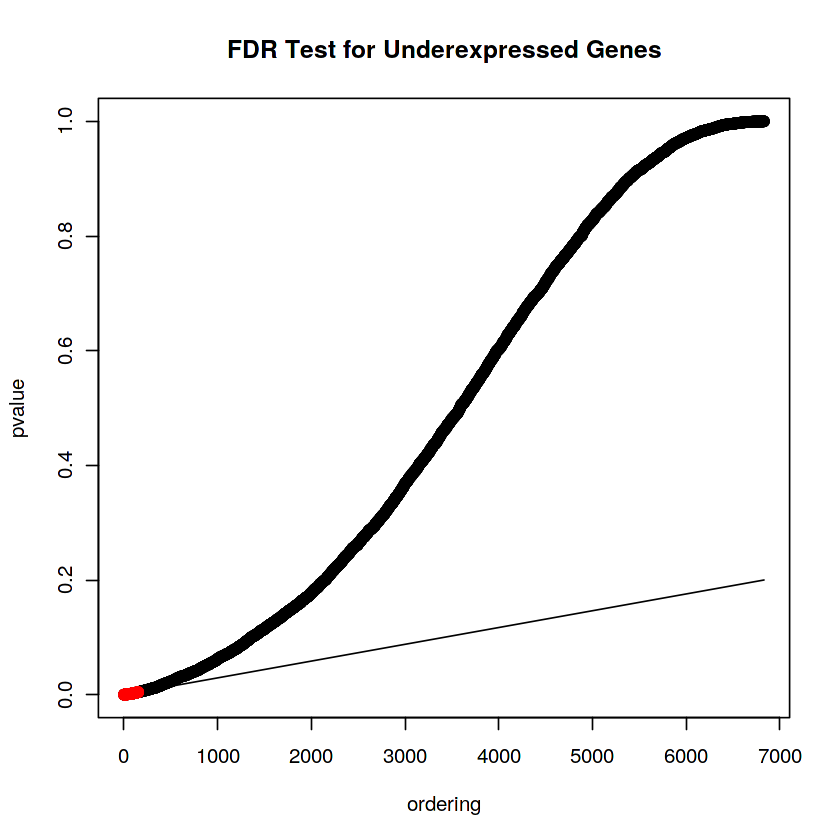

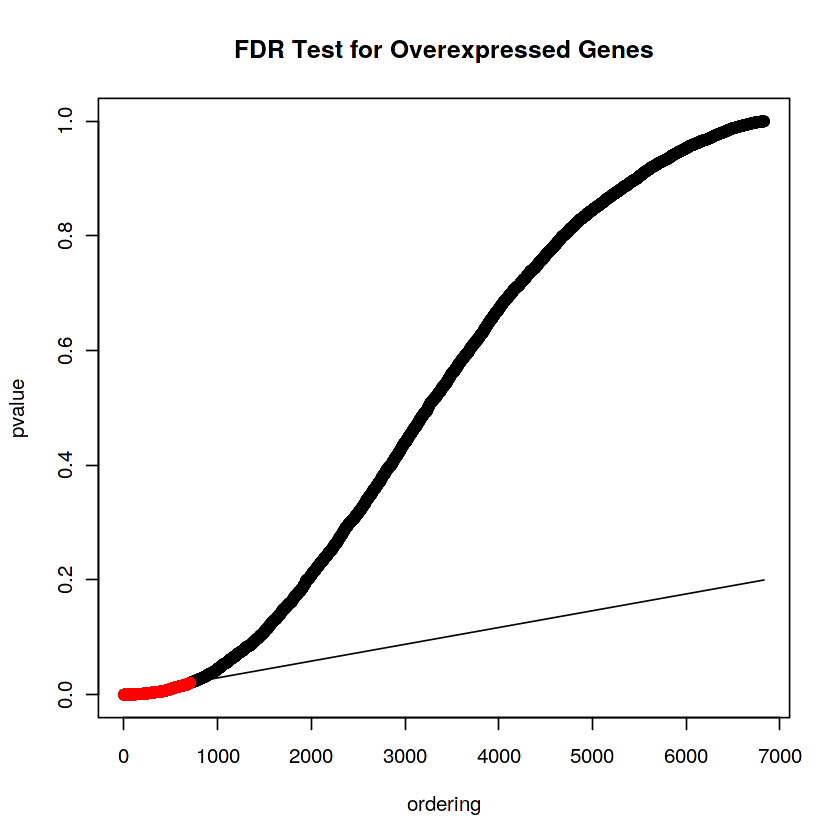

In [19]:
renal_data <- get_cancer_data("RENAL")
significant_underexpressed_genes_vector[['RENAL']] <- fdr(apply(renal_data, 
                                                        2, mytfunc)[1,], 0.2, 
                                                        "underexpressed")
significant_overexpressed_genes_vector[['RENAL']] <- fdr(apply(renal_data, 
                                                        2, mytfunc)[2,], 0.2, 
                                                        "overexpressed")

### 4.13 CNS

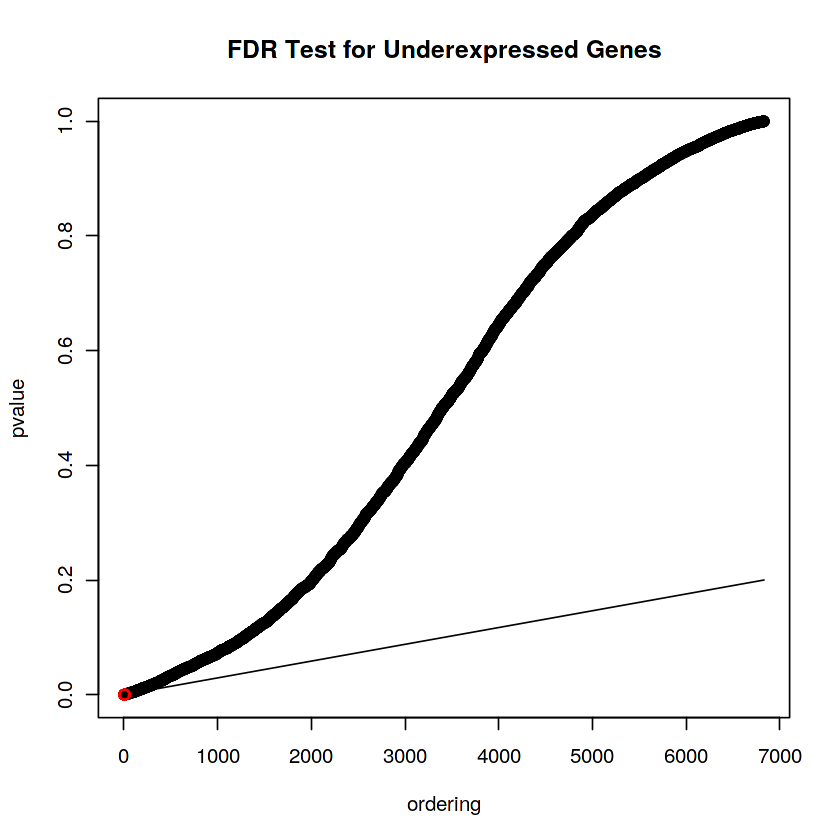

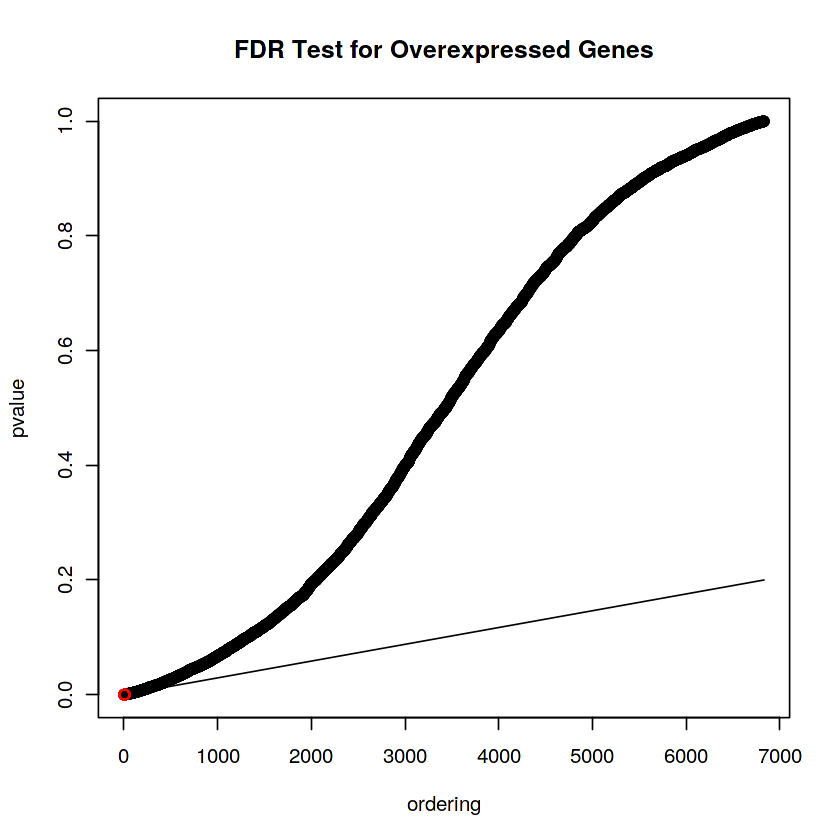

In [20]:
cns_data <- get_cancer_data("CNS")
significant_underexpressed_genes_vector[['CNS']] <- fdr(apply(cns_data, 
                                                        2, mytfunc)[1,], 0.2, 
                                                        "underexpressed")
significant_overexpressed_genes_vector[['CNS']] <- fdr(apply(cns_data, 
                                                        2, mytfunc)[2,], 0.2, 
                                                        "overexpressed")

### 4.14 OVARIAN

Warning message in max(pvec[I1], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in max(pvec[I1], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

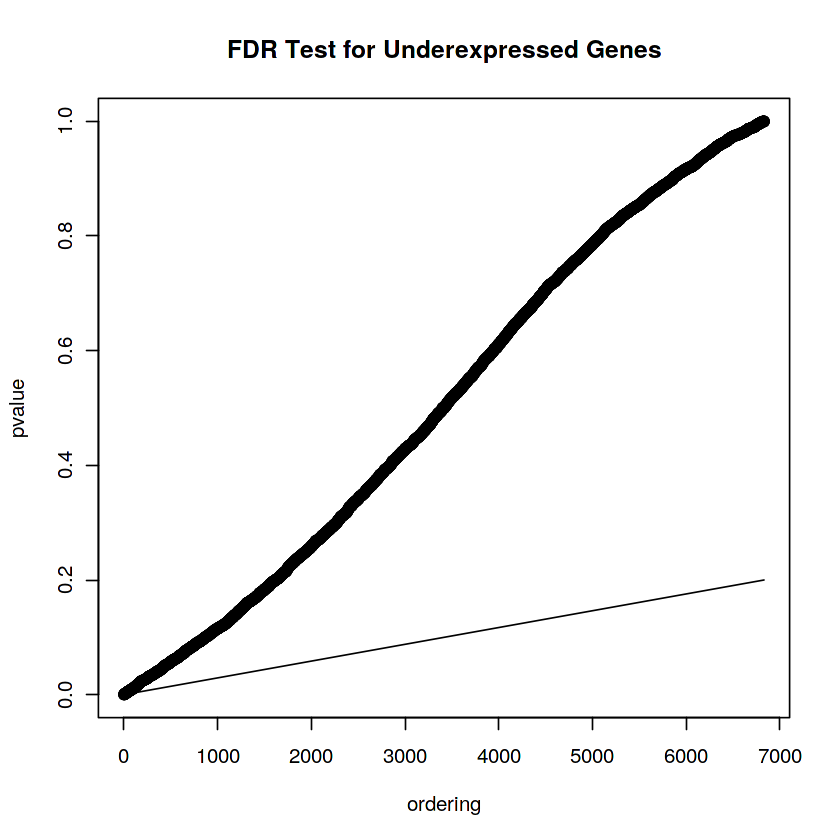

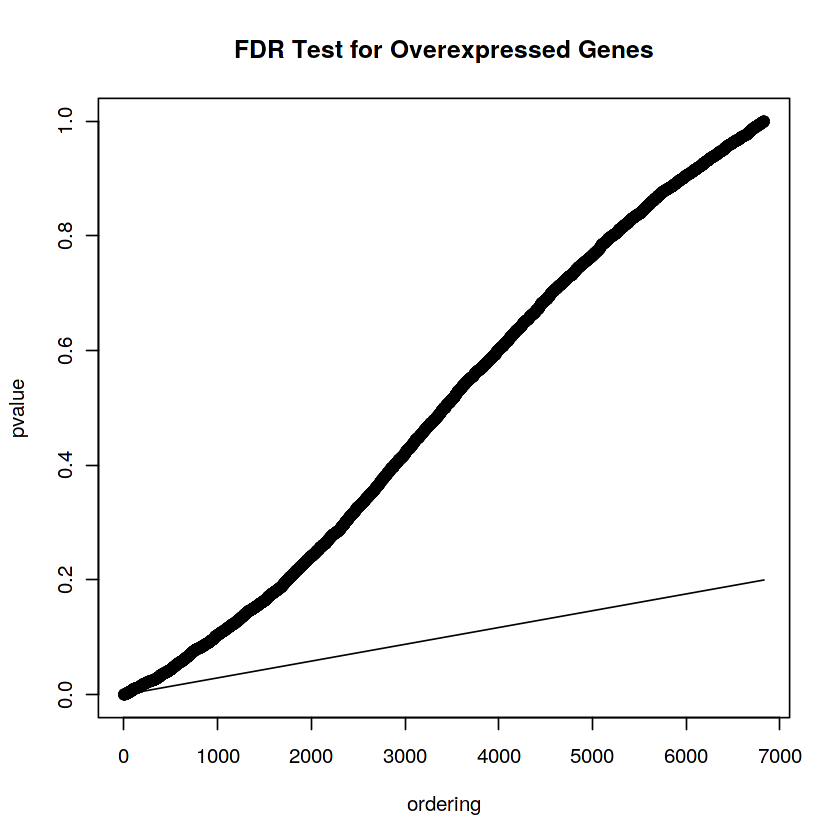

In [21]:
ovarian_data <- get_cancer_data("OVARIAN")
x <- fdr(apply(ovarian_data, 2, mytfunc)[1,], 0.2, "underexpressed")
y <- fdr(apply(ovarian_data, 2, mytfunc)[2,], 0.2, "overexpressed")

FDR test does not extract any significant gene for OVARIAN so we will not include it in our analysis since it has no genes.

## 5. Common Significant Genes between Different Cancers
Once we identify, the significant underexpressed and overexpressed genes in different cancers, we need to see which ones are common between the cancer types. This helps in creating medicines which can tackle multiple cancer types at once and is of significant value to the pharmaceutical companies.

There are many NA values in the significant genes and so we need to remove them first before looking at the common genes.

In [22]:
for (cancer_type in names(significant_overexpressed_genes_vector)){
    significant_overexpressed_genes_vector[[cancer_type]] = 
    (significant_overexpressed_genes_vector[[cancer_type]])
    [!is.na(significant_overexpressed_genes_vector[[cancer_type]])]
    significant_underexpressed_genes_vector[[cancer_type]] = 
    (significant_underexpressed_genes_vector[[cancer_type]])
    [!is.na(significant_underexpressed_genes_vector[[cancer_type]])]
}

Now that the NA values are removed in the individual significant genes of the cancers, we can visualize the common genes.

In [23]:
names(significant_overexpressed_genes_vector)

[1] "COLON"    "LEUKEMIA" "PROSTATE" "MELANOMA" "NSCLC"    "BREAST"   "RENAL"   
[8] "CNS"

### 5.1 Comparing 2 Cancers at a time
We first start with comparint 2 genes at a time. We create a utility function to plot the common genes and print them

In [24]:
get_common_significant_genes <- function(cancer1, cancer2, gene_type, color1, color2){
    x <- c()
    if (gene_type == "underexpressed"){
        x[[cancer1]] <- significant_underexpressed_genes_vector[[cancer1]]
        x[[cancer2]] <- significant_underexpressed_genes_vector[[cancer2]]
        main_string <- "Common Underexpressed Genes between Different Cancer Types"
        ylab_string <- "Significant Underexpressed Genes"
    }
    else{
        x[[cancer1]] <- significant_overexpressed_genes_vector[[cancer1]]
        x[[cancer2]] <- significant_overexpressed_genes_vector[[cancer2]]
        main_string <- "Common Overexpressed Genes between Different Cancer Types"
        ylab_string <- "Significant Overexpressed Genes"
    }
    
    stripchart(x,
    main = main_string,
    xlab="Cancer Types",
    ylab = ylab_string,
    method = "stack",
    col = c(color1, color2),
    offset = 100, 
    pch = 19,
    vertical = TRUE
    )
    
    common_genes <- Reduce(intersect, list(x[[cancer1]], x[[cancer2]]))
    number_of_common_genes <- length(common_genes)
    print("The common genes are:")
    print(common_genes)
    print("The number of common genes are:")
    print(number_of_common_genes)
}

### 5.1.1 COLON vs LEUKEMIA

[1] "The common genes are:"
  [1] 5856 5950 5956 5859 5535 6431 5961 5913 5960 5855 4099 6001 4105 4168 5962
 [16] 6135 5824 5910 5955 5804 6000 6072 5852 6277 5898 5830 5874  481 5899 5425
 [31] 5718 5840 6417 4395 5829 5952 4095 5948 4009 5984 6055 5686 6054 4156 5872
 [46] 5972 5825 5971 5430 6133 5814 5803 3936 6063 4331 5914 6254 5251 5982 4289
 [61] 6249 5760 5815 4164 5862 5891 6091 5941 5964 5810 6053 4341 6065 5839 4330
 [76] 6203 4288 5915 5813 5965 5892 5886 4011 4103 5912 5946 4846 6099 6092 6382
 [91] 6137 5953 5909 5864 6031 5870 4423 6245 5676 6064 4286 6134 6172 5113 5871
[106] 6082 4359 5809 5869 5943 5970 5939 5537 6097 6006 6098 6141 5884 6073 6581
[121] 5947 5805 4254 5101 5837    1 5868 5935 6123 5896 5890 5878 5934 6044 6140
[136] 6695 5684 5875 6278 4158 4373 5614 5885 4267 5937 6015 4005 5887 6104 4106
[151] 5903 6051 6414 5936 4163 6085 5933 6035 5687 5109 5938 6142 4352 4353 6290
[166] 6218 6023 4290 5411 5873 4488 5866 6101 5951 4257 6136 5534 5081 5429 5636


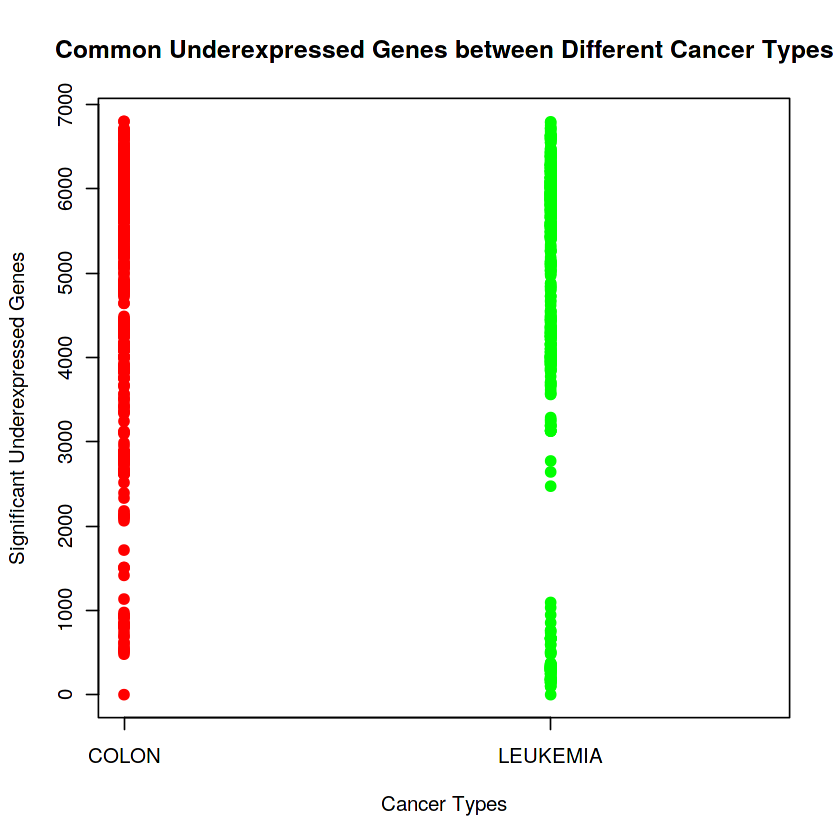

In [25]:
get_common_significant_genes("COLON", "LEUKEMIA", "underexpressed", "red", "green")

[1] "The common genes are:"
 [1] 1868 1902 2130 1847 1697 1916 3296 2047 1871  392 3295 1728 1346 1841 1903
[16] 3294 1572 1915 1696 1904 1936 1968  232 1922 2282 1929 1694 2024  391 2385
[31] 2287 1021 2171 2423 2129 1887 2142 1901 1768 1777 1956 1894 1695 1918 2090
[46] 2038 3297 1864 1870 2151 2128 1691 2131 1769 1347 1519 2148 1815 2042 1762
[61] 3595 1538 2059 1563 2127 1835 1452 1849  468 2135 2008 1451 2283 1560 1313
[76] 1792 1914 3607 2943 1450 2147 1539 1453 1818 6774 2298 1850  739 1982 1301
[91] 2025 1927 2424 2091 1893 2049 2187 2245 3406
[1] "The number of common genes are:"
[1] 99


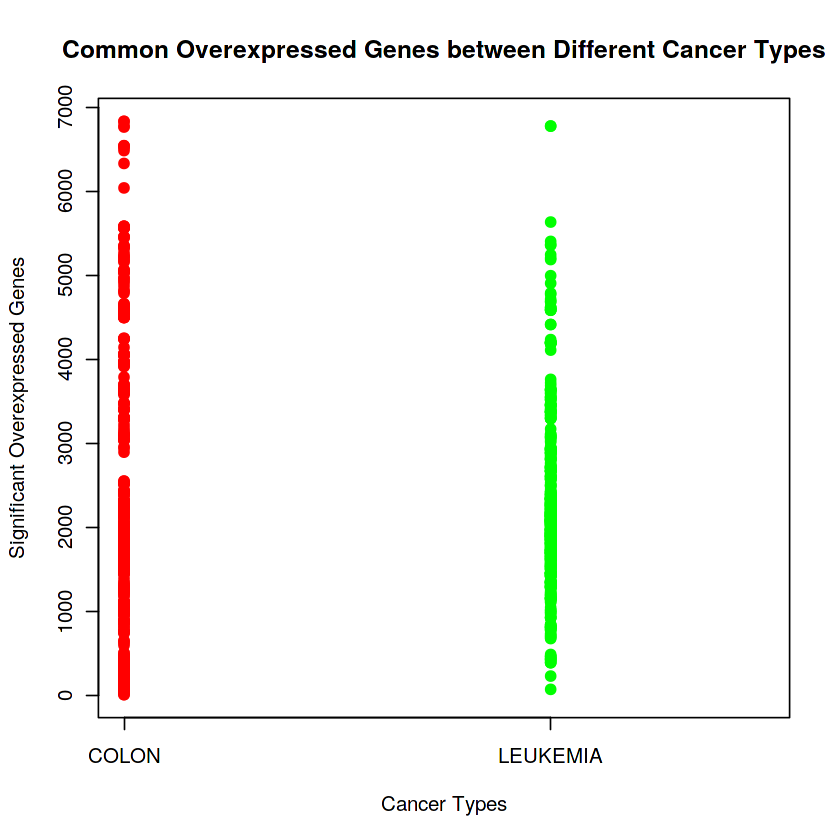

In [26]:
get_common_significant_genes("COLON", "LEUKEMIA", "overexpressed", "red", "green")

We see that there are 190 common genes which are underexpressed between COLON and LEUKEMIA. There are 99 common genes which are overexpressed between the 2 cancers. This means that there are higher chances of creating a medicine for the underexpressed genes and we could use the same medicine to tackle both the cancer types.

### 5.1.2 COLON vs RENAL

[1] "The common genes are:"
[1] 2632 2777 2813
[1] "The number of common genes are:"
[1] 3


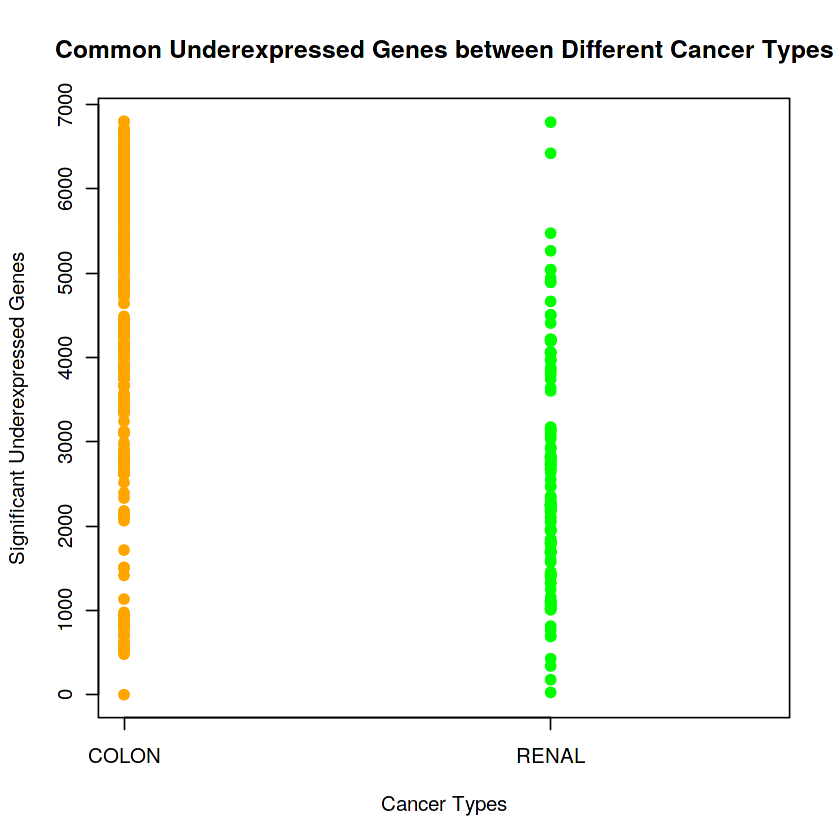

In [27]:
get_common_significant_genes("COLON", "RENAL", "underexpressed", "orange", "green")

[1] "The common genes are:"
 [1]  282 6535  252   98  152  354  355  100  151 5350  470  175 4251   11 5338
[1] "The number of common genes are:"
[1] 15


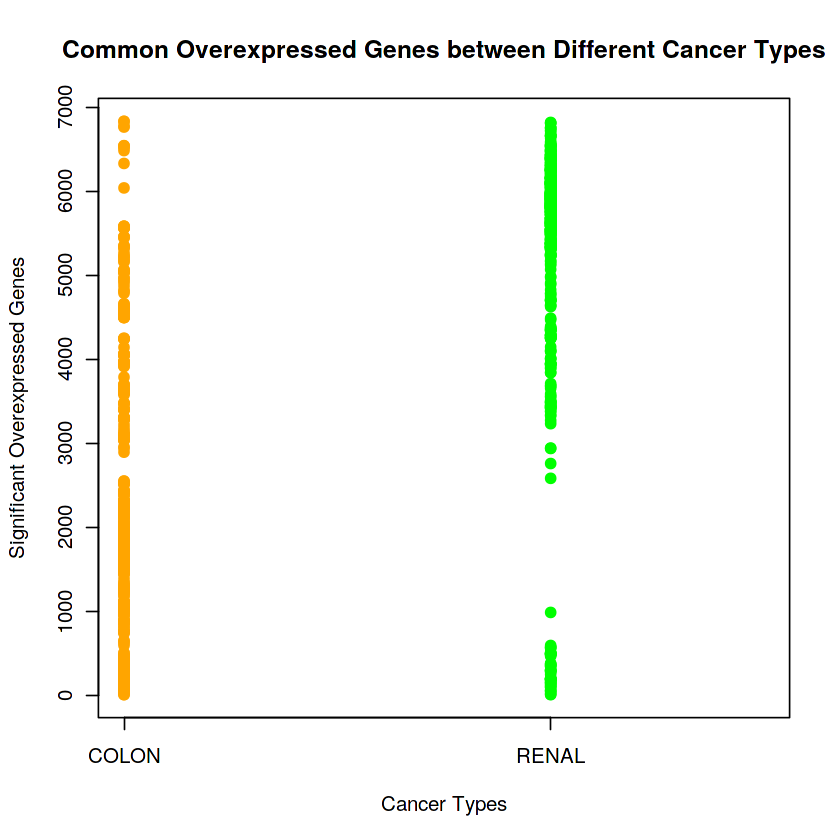

In [28]:
get_common_significant_genes("COLON", "RENAL", "overexpressed", "orange", "green")

### 5.1.3 RENAL vs LEUKEMIA

[1] "The common genes are:"
[1] 4216 4214 4213 3963 4215
[1] "The number of common genes are:"
[1] 5


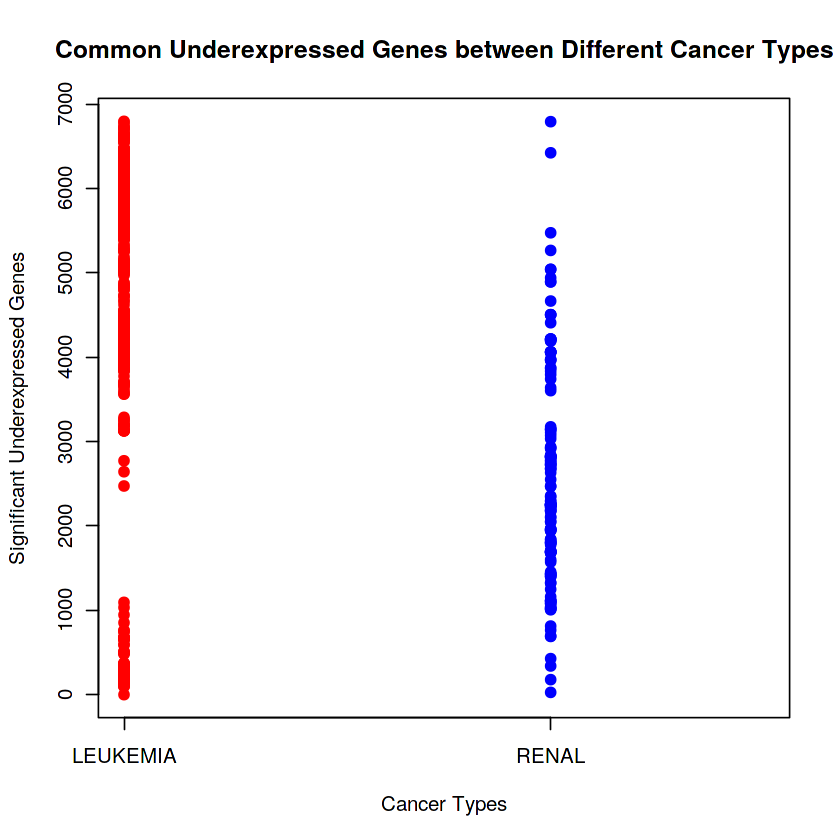

In [29]:
get_common_significant_genes("LEUKEMIA", "RENAL", "underexpressed", "red", "blue")

[1] "The common genes are:"
[1] 3380 2944 3381 3445 3459 2939 5632
[1] "The number of common genes are:"
[1] 7


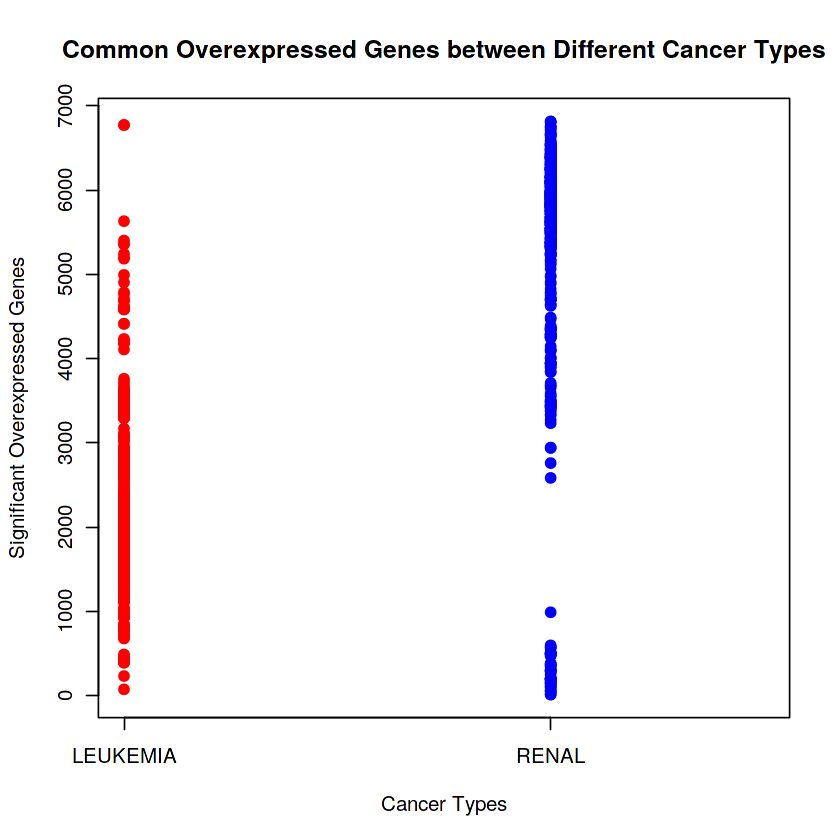

In [30]:
get_common_significant_genes("LEUKEMIA", "RENAL", "overexpressed", "red", "blue")

We see that in LEUKEMIA and RENAL, there are very few common genes between the 2, so its harder to create a common medicine to tackle these 2 types of cancer.

### 5.1.5 BREAST vs RENAL

[1] "The common genes are:"
integer(0)
[1] "The number of common genes are:"
[1] 0


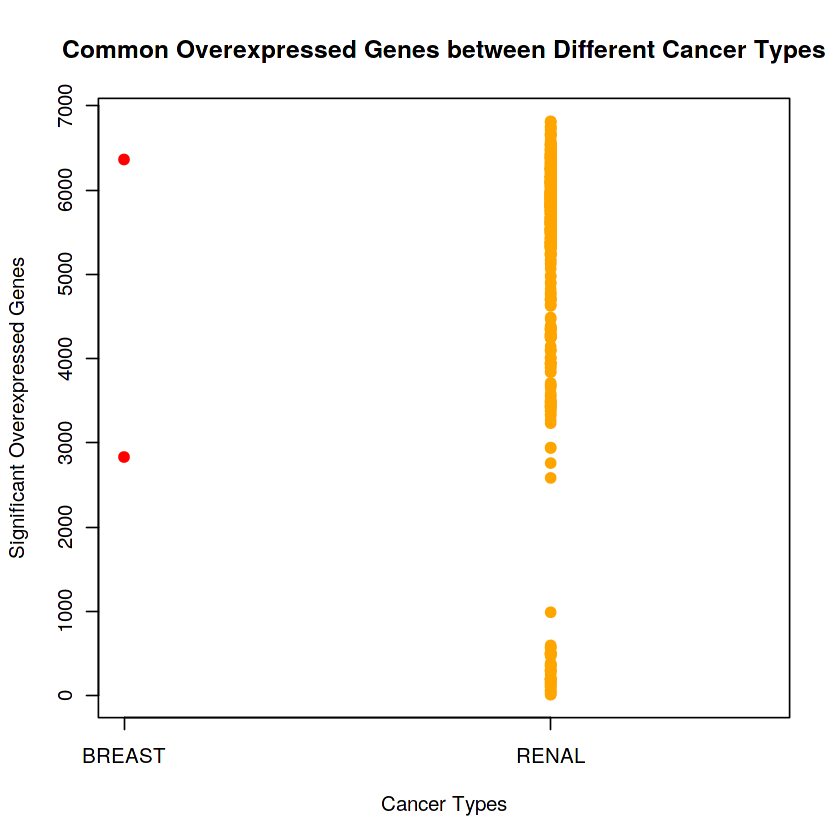

In [31]:
get_common_significant_genes("BREAST", "RENAL", "overexpressed", "red", "orange")

[1] "The common genes are:"
integer(0)
[1] "The number of common genes are:"
[1] 0


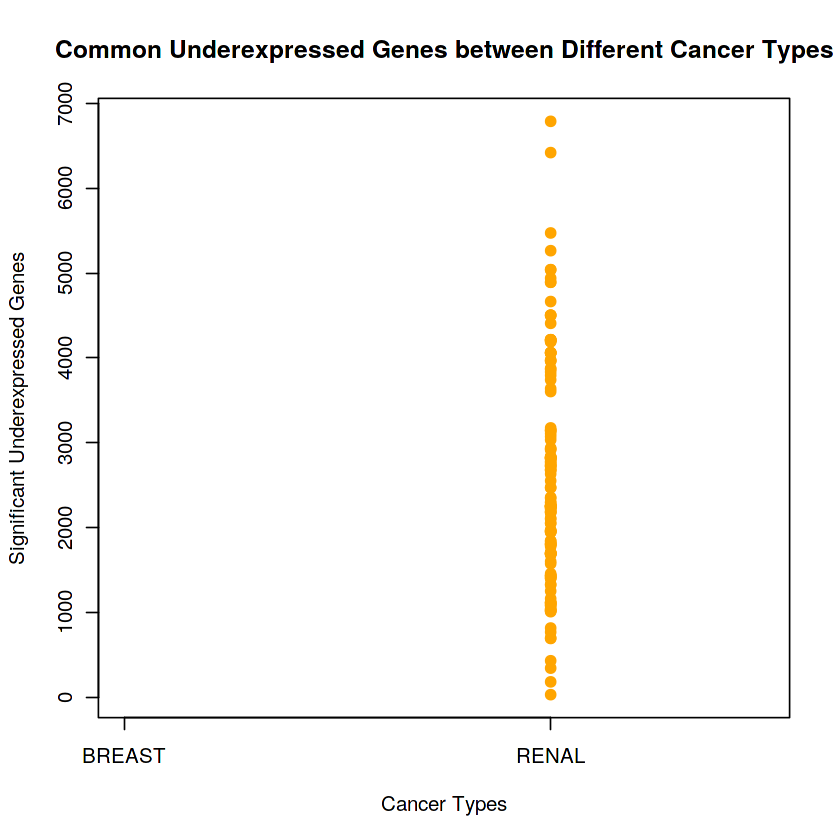

In [32]:
get_common_significant_genes("BREAST", "RENAL", "underexpressed", "red", "orange")

As we see, there are no common overexpressed and underexpressed genes between the BREAST and RENAL. Thus a cancer company cannot create common medicines to tackle both simultaneously.

### 5.1.6 LEUKEMIA vs MELANOMA

[1] "The common genes are:"
 [1] 2233 2733 5356  814 2395 4234 2163 4109 1297 1107 2247 1462 2732 2723 2606
[16] 2348 2164 2236 2347 1442 2716 3761 4192 2257 2159 2211 2158 2346 2235 2246
[31] 2724 2215 2126 2394  438 2221 2918 4193 4586 4195 2061 4185 4191 2224 2345
[46] 4587 4413 3520 2717 4205 2607 3370 2087 1430 2822 2726 1629 2270 4591
[1] "The number of common genes are:"
[1] 59


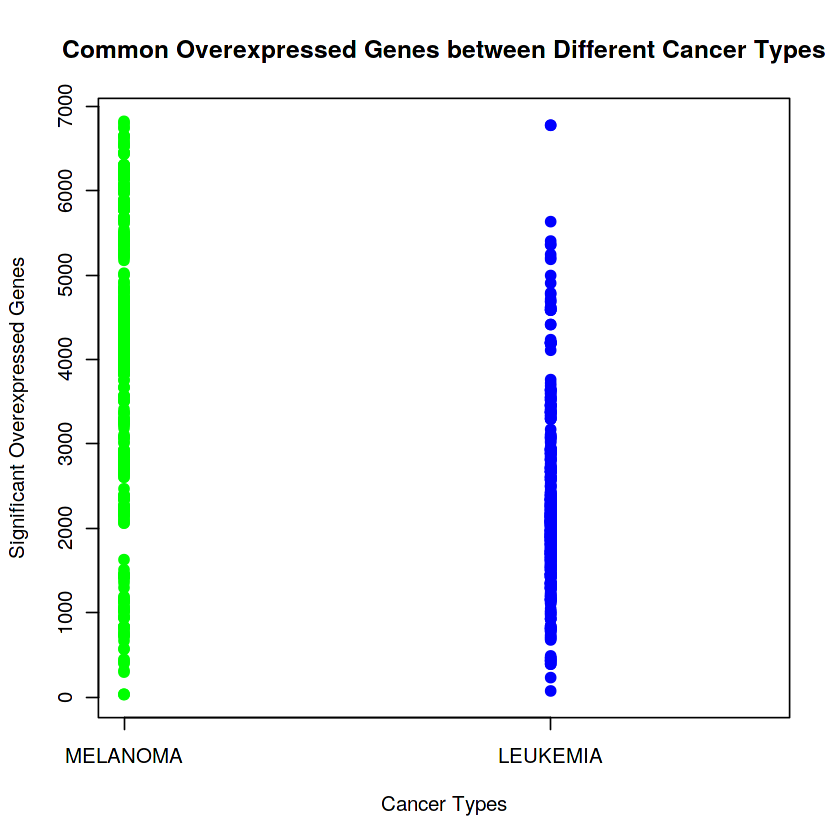

In [33]:
get_common_significant_genes("MELANOMA", "LEUKEMIA", "overexpressed", "green", "blue")

[1] "The common genes are:"
 [1]  196 5586 6399  287  251 5971  165  246  245 6369  325 5970 6080 6312  336
[16] 5839 5931  281 6081 6416 5558 6415 5746 6351  327 5437 6039  252  322 6388
[31]  332 5104 5972 5136 5559 5755 5453 5816 6390  181 5930 6370 6391 5742  159
[46] 5744  283  278 5452 5965 6275 6041 5463 6604 5567 5841  321 6414 5589 5584
[61]  143  329 5450 5837 5439 5761 5556 5762 5899 6392  167  214 5673 6384 5557
[76] 5932 5929  190 6382 5940  307  351 5924 5964 3233 6627 6380 4971
[1] "The number of common genes are:"
[1] 88


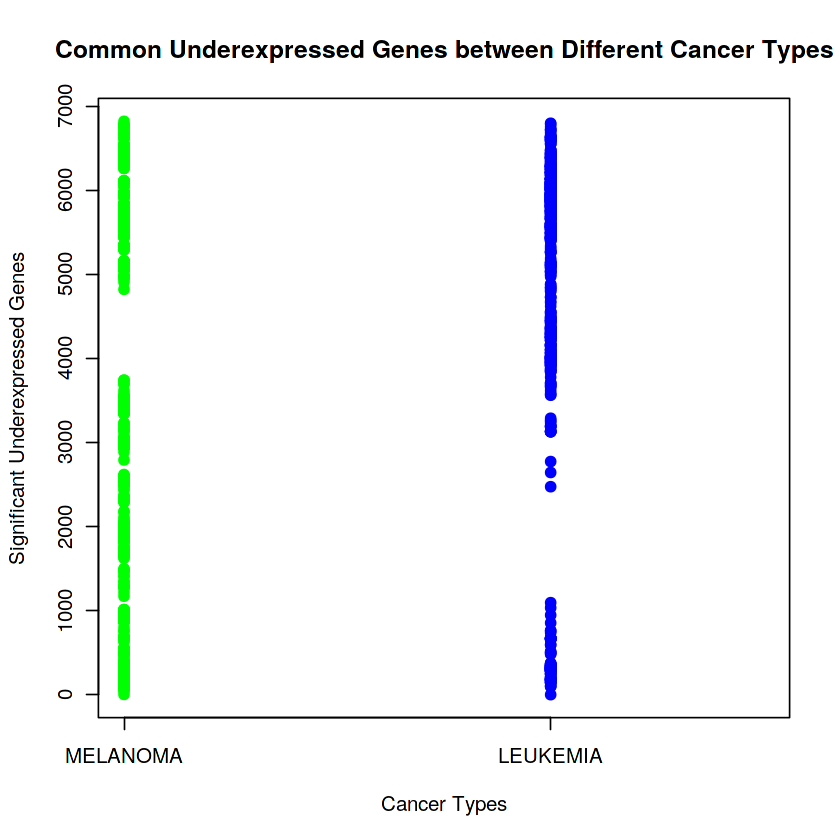

In [34]:
get_common_significant_genes("MELANOMA", "LEUKEMIA", "underexpressed", "green", "blue")

Now, lets try out 3 cancer types at a time

In [35]:
get_common_significant_genes_for_3_cancer_types <- function(cancer1, cancer2, cancer3, gene_type, color1, color2, color3){
    x <- c()
    if (gene_type == "underexpressed"){
        x[[cancer1]] <- significant_underexpressed_genes_vector[[cancer1]]
        x[[cancer2]] <- significant_underexpressed_genes_vector[[cancer2]]
        x[[cancer3]] <- significant_underexpressed_genes_vector[[cancer3]]
        main_string <- "Common Underexpressed Genes between Different Cancer Types"
        ylab_string <- "Significant Underexpressed Genes"
    }
    else{
        x[[cancer1]] <- significant_overexpressed_genes_vector[[cancer1]]
        x[[cancer2]] <- significant_overexpressed_genes_vector[[cancer2]]
        x[[cancer3]] <- significant_underexpressed_genes_vector[[cancer3]]
        main_string <- "Common Overexpressed Genes between Different Cancer Types"
        ylab_string <- "Significant Overexpressed Genes"
    }
    
    stripchart(x,
    main = main_string,
    xlab="Cancer Types",
    ylab = ylab_string,
    method = "stack",
    col = c(color1, color2, color3),
    offset = 100, 
    pch = 19,
    vertical = TRUE
    )
    
    common_genes <- Reduce(intersect, list(x[[cancer1]], x[[cancer2]], x[[cancer3]]))
    number_of_common_genes <- length(common_genes)
    print("The common genes are:")
    print(common_genes)
    print("The number of common genes are:")
    print(number_of_common_genes)
}

[1] "The common genes are:"
integer(0)
[1] "The number of common genes are:"
[1] 0


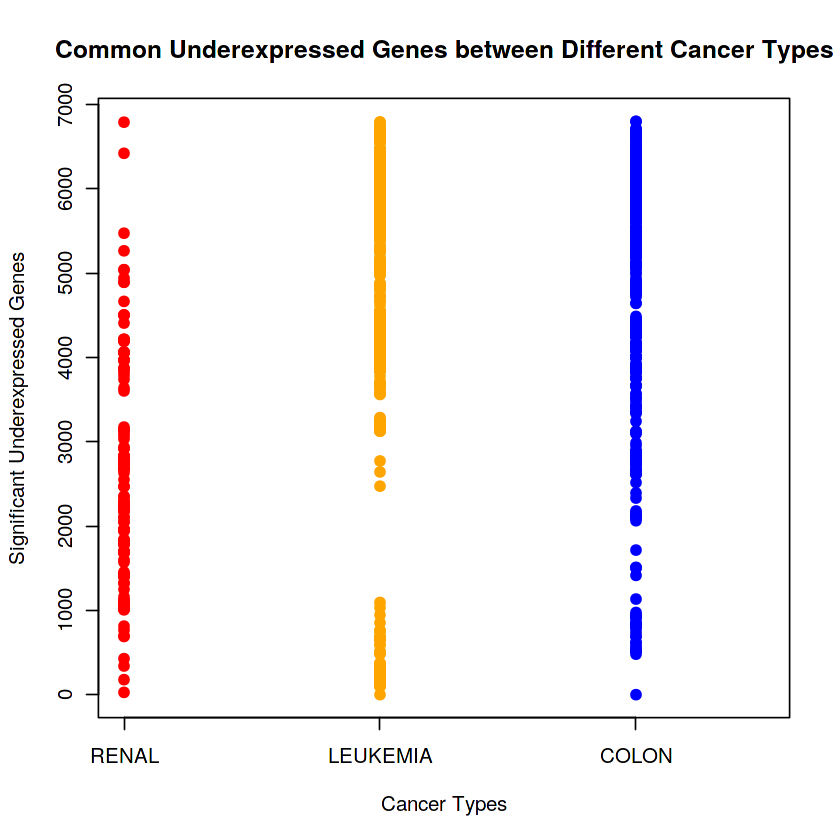

In [36]:
get_common_significant_genes_for_3_cancer_types("RENAL", "LEUKEMIA", "COLON", "underexpressed", "red", "orange", "blue")

[1] "The common genes are:"
[1] 5632
[1] "The number of common genes are:"
[1] 1


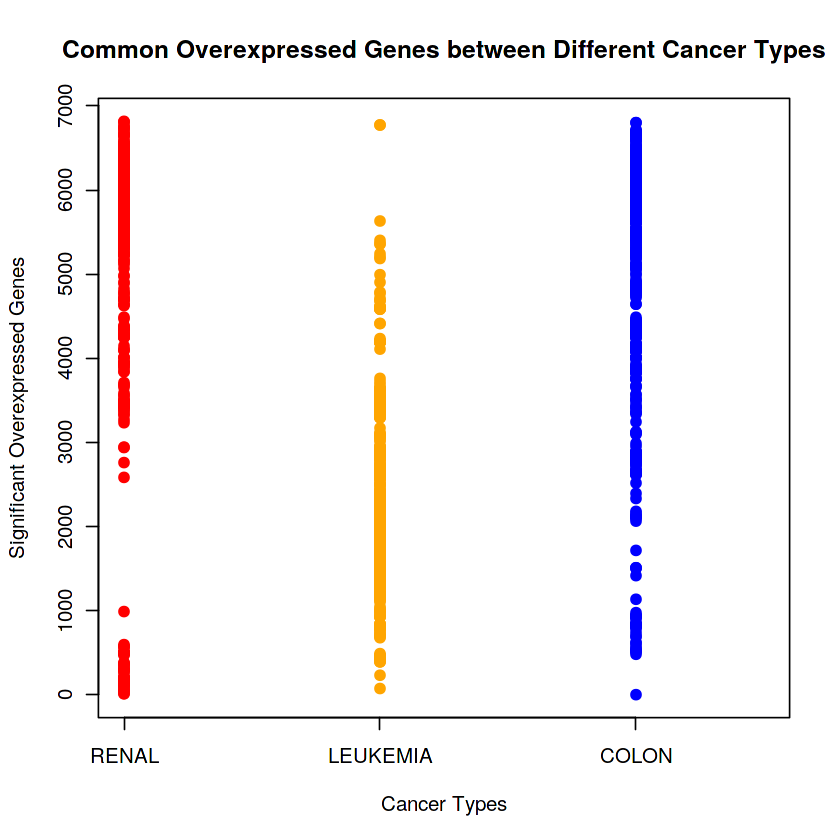

In [37]:
get_common_significant_genes_for_3_cancer_types("RENAL", "LEUKEMIA", "COLON", "overexpressed", "red", "orange", "blue")

We see that there are no overexpressed or underexpressed genes between the 3 cancer types and so no medicine can tackle the 3 of them simultaneously. Similarly, we can check for more combinations.

# THANK YOU!